In [1]:
# %pip install numpy matplotlib scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import decimate, envelope, fftconvolve
import pandas as pd

In [4]:
# normalization from -1 to 1
def simetric_min_max(signal):
    signal_copy = signal.copy()
    signal_copy = signal_copy.astype(float)
    min_val = np.min(signal_copy)
    max_val = np.max(signal_copy)
    normalized_signal = 2 * (signal_copy - min_val) / (max_val - min_val) - 1
    return normalized_signal

min_max = lambda x: (x - x.min()) / (x.max() - x.min())

# function to compute Shannon Energy Envelope
def see(signal, window_size):
    """
    Versión optimizada que preserva *exactamente* el comportamiento
    numérico del implementation original (incluyendo casos límite).
    """
    # replicate original's behavior: operate in float (default float64)
    x = np.array(signal, copy=True, dtype=float)
    # squared signal
    s2 = x * x
    # same small constant inside log as original
    shannon_energy = -s2 * np.log(s2 + 1e-10)

    n = s2.size
    edges = int(window_size // 2)
    start = edges
    end = n - edges

    envelope = np.zeros(n, dtype=shannon_energy.dtype)

    # preserve edge assignments exactly like original
    if start > 0:
        envelope[:start] = shannon_energy[:start]
    if end < n:
        envelope[end:] = shannon_energy[end:]

    # Only perform the middle-window smoothing when the original loop would run.
    # The original loop runs for i in range(start, end).
    if start < end:
        # Special case: window_size == 1
        # The original code with window_size==1 computes slices i:i (empty)
        # and divides by 1, resulting in zeros for the middle region.
        # We replicate that behavior (i.e., do nothing — it's already zeros).
        if window_size == 1:
            pass
        else:
            k = 2 * edges  # length of slice used in original: i-edges : i+edges  -> length = 2*edges
            # If k == 0 we would be in a degenerate case; let Python raise if division by zero occurs later
            if k > 0 and (end - start) > 0:
                # convolution with ones gives sums over windows of length k.
                # mapping: envelope[i] (for i in [start, end-1]) should get
                # sum(shannon_energy[i-edges : i+edges]) / window_size
                # which corresponds to np.convolve(..., ones(k), mode='valid')[0 : end-start]
                valid = np.convolve(shannon_energy, np.ones(k, dtype=shannon_energy.dtype), mode='valid')
                # assign only the needed portion (exclude the last valid value to match original indexing)
                envelope[start:end] = valid[: (end - start) ] / float(window_size)

    return envelope.astype(np.float32)

def cross_correlation(x, y):
    """
    Optimized version that preserves exactly the original numeric behavior.
    Returns an array `cxx` of length N = min(len(x), len(y)) where
    cxx[lag] = sum_{i=0}^{N-lag-1} x[i]*y[i+lag] / (N - lag).
    """
    x = np.asarray(x)
    y = np.asarray(y)

    N = min(x.size, y.size)
    if N == 0:
        return np.zeros(0)

    # operate in float64 like the original (no unexpected casts)
    x0 = x[:N].astype(np.float64, copy=False)
    y0 = y[:N].astype(np.float64, copy=False)

    # convolution with reversed y0 gives the required dot-products in C
    conv = np.convolve(x0, y0[::-1], mode="full")  # length 2*N - 1

    # For lag = 0..N-1 the numerator is conv[N-1 - lag], so take conv[N-1::-1]
    numerators = conv[N - 1 :: -1]  # yields [conv[N-1], conv[N-2], ..., conv[0]]

    # denominators: [N, N-1, ..., 1]
    denominators = np.arange(N, 0, -1, dtype=np.float64)

    return numerators / denominators

def next_pow2(n: int) -> int:
    """Small helper: next power of two >= n (for n >= 1)."""
    if n <= 1:
        return 1
    return 1 << ((n - 1).bit_length())

def cross_correlation_fft(x, y, max_fft_len=2**22, dtype=np.float64):
    """
    Cross-correlation using FFT convolution with optional overlap-add blocking.

    Computes the same correlation definition as your original function:
      r[lag] = sum_{i=0}^{N-lag-1} x[i]*y[i+lag] / (N - lag)
    for lag = 0..N-1, where N = min(len(x), len(y)).

    Parameters
    ----------
    x, y : array-like
        Input signals.
    max_fft_len : int
        Maximum allowed FFT length (points) used internally. If full FFT
        would be larger, the function will process x in blocks so the FFT
        for each block fits within this size.
    dtype : data-type
        Working dtype (default float64). Use float32 to reduce memory at
        the cost of precision.

    Returns
    -------
    cxx : np.ndarray of shape (N,)
        Cross-correlation values for lags 0..N-1 (dtype == dtype).
    """
    x = np.asarray(x, dtype=dtype)
    y = np.asarray(y, dtype=dtype)

    N = min(x.size, y.size)
    if N == 0:
        return np.zeros(0, dtype=dtype)

    x0 = x[:N]
    y0 = y[:N]
    y_rev = y0[::-1]

    # If a single FFT of size next_pow2(N + N - 1) fits, do single fftconvolve
    full_required = next_pow2((N + N - 1))
    if full_required <= max_fft_len:
        conv = fftconvolve(x0, y_rev, mode="full")
    else:
        # Overlap-add: choose block length L for chunks of x0 so that
        # next_pow2(L + N - 1) <= max_fft_len  --> L <= max_fft_len - (N - 1)
        # ensure L >= 1
        max_L = max(1, max_fft_len - (N - 1))
        # If max_L is tiny (<=0) we fallback to single fftconv anyway (may crash)
        # but we guard with min.
        L = int(min(N, max_L))
        if L <= 0:
            # Fallback (rare): try single fftconvolve (may raise MemoryError if impossible)
            conv = fftconvolve(x0, y_rev, mode="full")
        else:
            conv_len = 2 * N - 1
            conv = np.zeros(conv_len, dtype=dtype)
            # Process x0 in blocks of length L
            for start in range(0, N, L):
                x_block = x0[start : start + L]
                chunk_conv = fftconvolve(x_block, y_rev, mode="full")
                # accumulate into conv at offset 'start'
                conv[start : start + chunk_conv.size] += chunk_conv

    # Numerators: conv[N-1], conv[N-2], ..., conv[0]
    numerators = conv[N - 1 :: -1] if conv.size >= N else conv[N - 1 :: -1]  # safe slice
    # denominators: N, N-1, ..., 1
    denominators = np.arange(N, 0, -1, dtype=dtype)

    return (numerators / denominators).astype(dtype, copy=False)

In [5]:
def cross_correlation3(x, y):
    max_len = min(len(x), len(y))
    cxx = np.zeros(max_len) 
    for lag in range(max_len):
        seg_x = x[:max_len - lag] 
        seg_y = y[lag:max_len] 
        cxx[lag] = np.sum(seg_x * seg_y) / (max_len - lag)
    return cxx

def cross_correlation4(x, y):
    """
    Vectorized version that preserves the exact behavior of the original:
      cxx[lag] = sum_{i=0..N-1-lag} x[i]*y[i+lag] / (N - lag)
    where N = min(len(x), len(y)), for lag = 0..N-1.
    Returns dtype float64 (same as original).
    """
    xa = np.asarray(x, dtype=float)
    ya = np.asarray(y, dtype=float)

    N = min(xa.size, ya.size)
    if N == 0:
        return np.zeros(0, dtype=np.float64)

    xa = xa[:N]
    ya = ya[:N]

    # full correlation length = 2*N - 1
    corr_full = np.correlate(xa, ya, mode='full')  # length 2*N-1

    # IMPORTANT: for lag = 0..N-1 the desired sum is at index (N-1 - lag)
    # so we take corr_full[N-1], corr_full[N-2], ..., corr_full[0].
    sums = corr_full[N - 1::-1].astype(np.float64)[:N]

    denom = np.arange(N, 0, -1, dtype=np.float64)  # [N, N-1, ..., 1]
    return (sums / denom).astype(np.float64)

def cross_correlation_fft2(x, y, exact=False):
    """
    Fast cross-correlation for non-negative lags using FFT convolution.

    Comportamiento:
      cxx[lag] = sum_{i=0..N-1-lag} x[i]*y[i+lag] / (N - lag)
    con N = min(len(x), len(y)), lag = 0..N-1.

    Parámetros:
    - x, y : array-like
    - exact : bool (default False). Si True, calcula la correlación con el método
      directo (suma por ventana) para garantizar igualdad bit-a-bit con la
      implementación original (más lento).

    Retorna:
    - np.ndarray dtype=float64 con longitud N
    """
    # Forzar arrays y dtype float64 (coincide con comportamiento original)
    xa = np.asarray(x, dtype=np.float64)
    ya = np.asarray(y, dtype=np.float64)

    N = min(xa.size, ya.size)
    if N == 0:
        return np.zeros(0, dtype=np.float64)

    # Si se pide exactitud bit-a-bit, usamos el método directo (lento pero idéntico).
    if exact:
        out = np.zeros(N, dtype=np.float64)
        for lag in range(N):
            seg_x = xa[: N - lag]
            seg_y = ya[lag: N]
            out[lag] = np.sum(seg_x * seg_y) / float(N - lag)
        return out

    # Truncar a N muestras (como en la versión original)
    xa = xa[:N]
    ya = ya[:N]

    # conv = xa * reverse(ya)  (la convolución con la reversa produce los sums requeridos)
    conv = fftconvolve(xa, ya[::-1], mode='full')

    # Conv viene en longitud 2*N-1; por ruido numérico puede tener una pequeña parte imaginaria:
    conv = np.real(conv)

    # Para lag = 0..N-1, el sum correspondiente está en conv[index = N-1 - lag].
    # Extraemos conv[N-1], conv[N-2], ..., conv[0] y tomamos los primeros N valores.
    sums = conv[N - 1 :: -1][:N].astype(np.float64)

    denom = np.arange(N, 0, -1, dtype=np.float64)  # [N, N-1, ..., 1]
    return (sums / denom).astype(np.float64)

In [6]:
audio_path = 'audios/pcg-julia2.wav'
# ecg = pd.read_csv('/home/david/Documents/ECG_delineation/ecg-sanos/wetransfer_ecgs_2024-09-09_1340/377-Bruno/Estudio.vak') this does not work
ecg = []
with open('/home/david/Documents/ECG_delineation/ecg-sanos/wetransfer_ecgs_2024-09-09_1340/ecg-julia/Estudio.vak', 'r') as f:
    lines = f.readlines()
    for line in lines:
        ecg.append([x for x in line.split()])

ecg_x = np.asarray([np.float32(x[0]) for x in ecg[1:]], dtype=np.float32)
ecg_2 = np.asarray([np.float32(x[2]) for x in ecg[1:]], dtype=np.float32)
ecg_2 /= np.max(np.abs(ecg_2))
sampling_freq, audio = wavfile.read(audio_path)

In [7]:
audio = audio.astype(np.float32)
# audio = decimate(audio, 20)
audio /= np.max(np.abs(audio))  # normalize to -1 to 1
# audio = min_max(audio)
audio_see = envelope(audio, residual=None)
audio = decimate(audio, 20)
audio_see = decimate(audio_see, 20)

In [18]:
cxx2 = cross_correlation_fft2(audio_see, ecg_2)

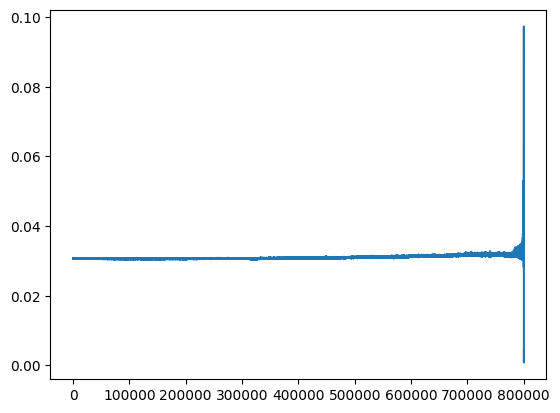

In [19]:
plt.plot(cxx2)
plt.show()

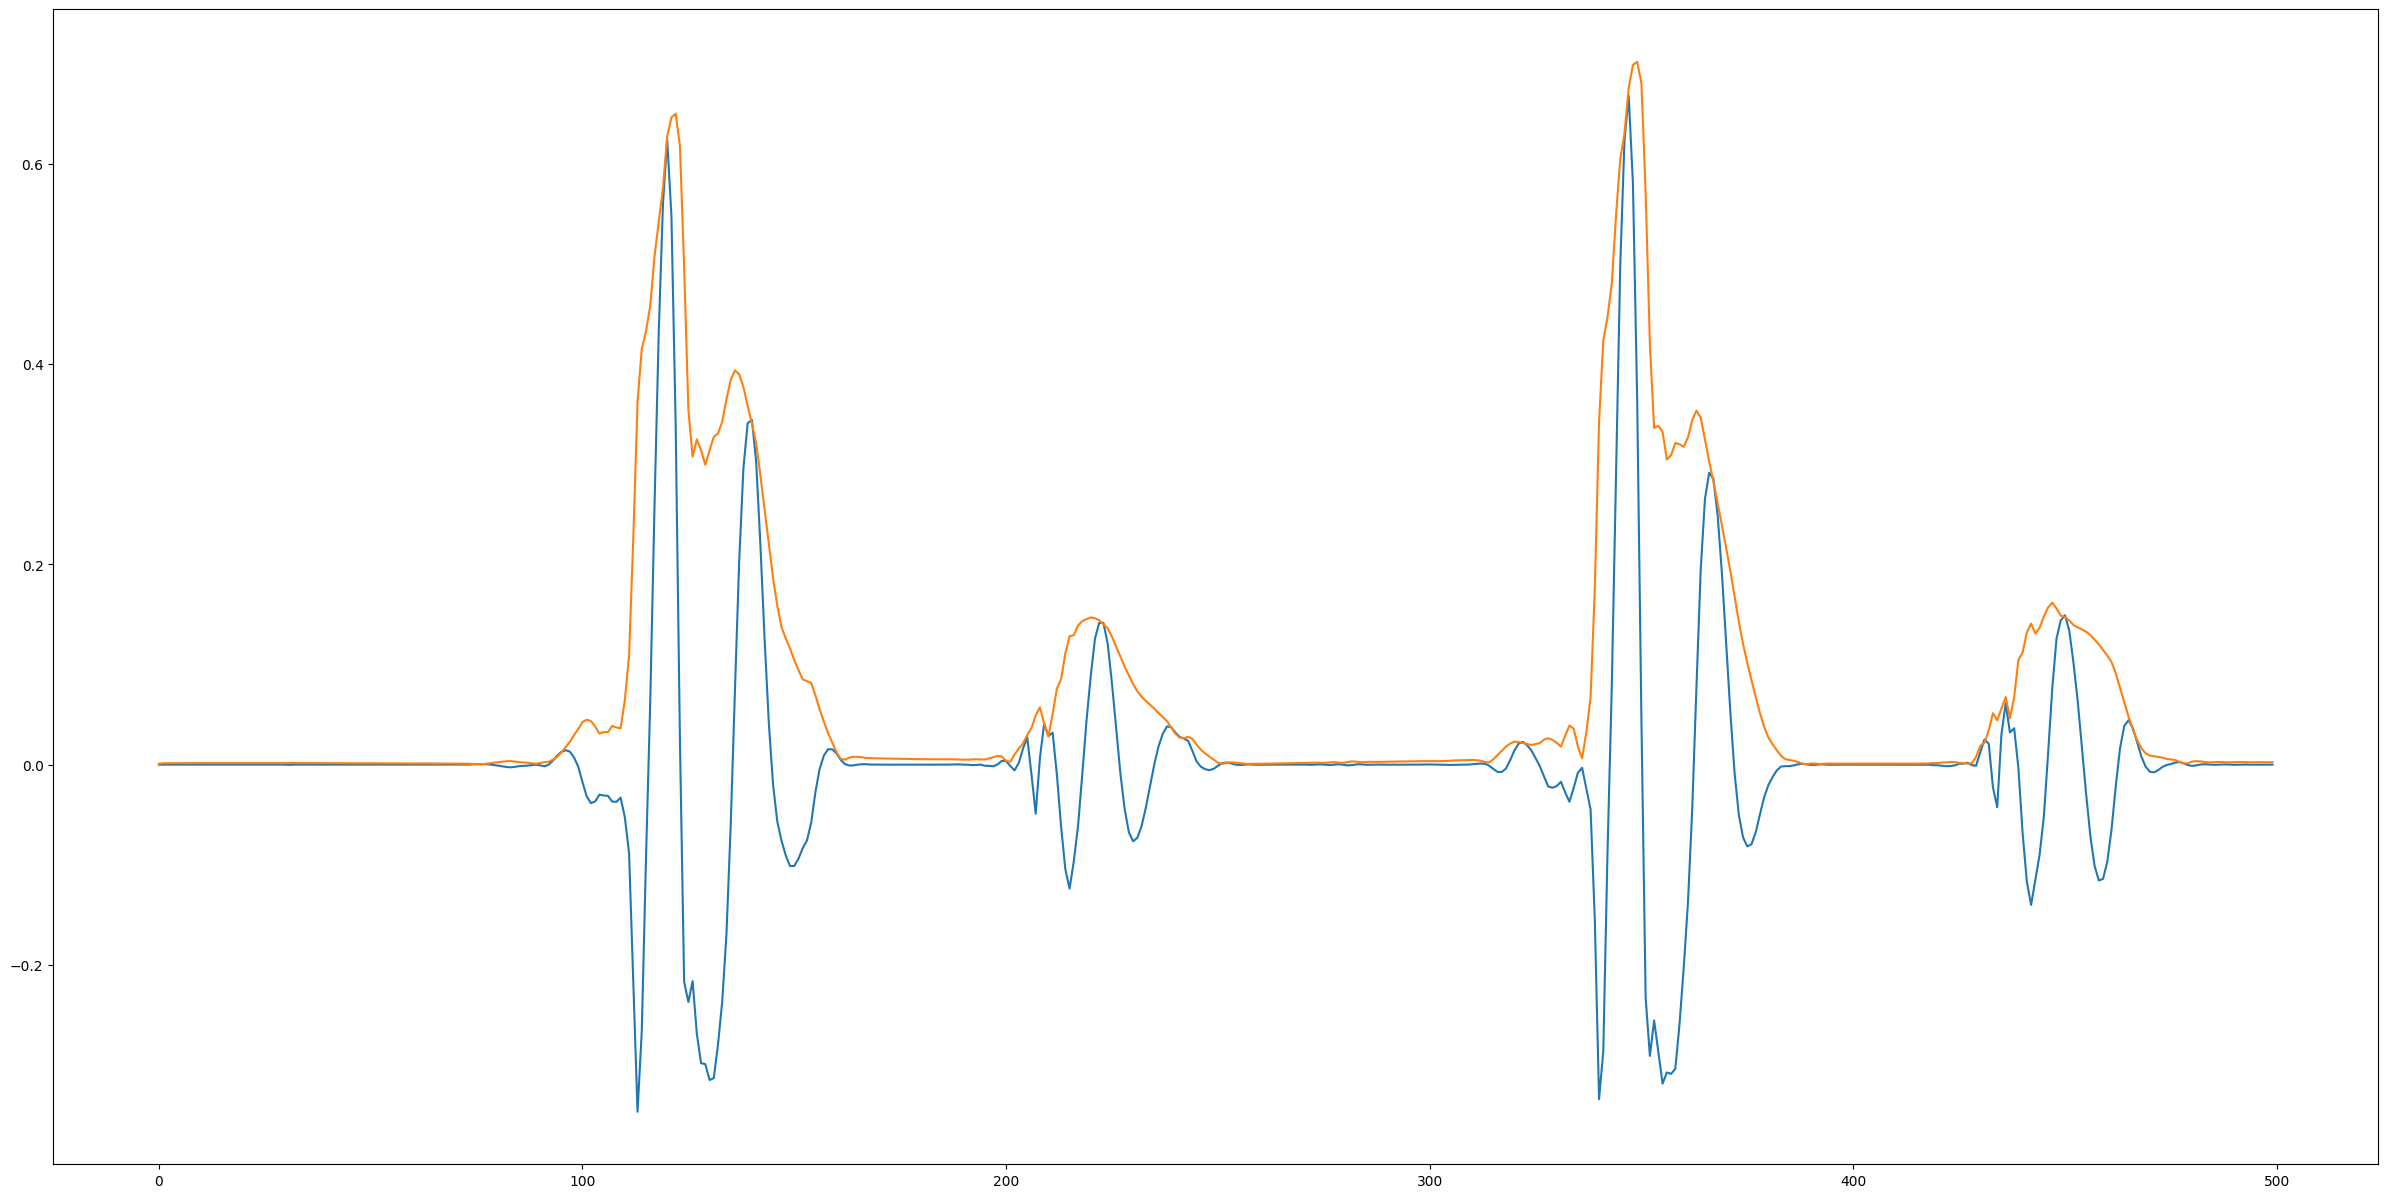

In [ ]:
n = 500
plt.figure(figsize=(30,15))
plt.plot(audio[:n])
plt.plot(audio_see[:n])
plt.show()